In [1]:
import jax.numpy as jnp
import jax.random as jrd

import parametrization_cookbook.jax as pc
import sdg4varselect.plotting as sdgplt

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Model sepecification
Le modèle que l'on souhaite étudier est le suivant :

$$Y_{ij} | b_{i} \sim \mathcal N(\eta_{ij}, 1)$$

Où $\eta_{ij} =\sum_{k=1}^p x_{ij,k} \beta_{k} + b_i ~, b_i\sim\mathcal N(0, \sigma_b^2=0.1^2)$ et $b_i  \sim \mathcal N(\mu, \Gamma^2)$,  X= [Ut, U']

Le code ci-dessous le définie pour python.

In [2]:
def m(
    params, times: jnp.ndarray, b: jnp.ndarray, cov: jnp.ndarray, **kwargs
) -> jnp.ndarray:

    out = (cov @ params.beta).reshape(times.shape) + b[:, None]
    assert out.shape == times.shape
    return out

In [3]:
import functools
from jax import jit


from sdg4varselect.models import AbstractMixedEffectsModel, AbstractHDModel


class LinearMixedEffectsModel(AbstractMixedEffectsModel, AbstractHDModel):
    """define a logistic mixed effects model"""

    def __init__(self, N=1, J=1, P=1, **kwargs):
        AbstractHDModel.__init__(self, P=P)
        AbstractMixedEffectsModel.__init__(self, N=N, J=J, me_name=["b"], **kwargs)

    def init_parametrization(self):
        self._parametrization = pc.NamedTuple(
            mean_latent=pc.Real(shape=(1,), scale=(1,)),
            cov_latent=pc.MatrixDiagPosDef(dim=1, scale=(1,)),
            var_residual=pc.RealPositive(scale=1),
            beta=pc.Real(scale=1, shape=(self.P,)),
        )
        self.parametrization_size = self._parametrization.size

    @property
    def name(self):
        return f"tutorial_lmem_N{self.N}_J{self.J}_P{self.P}"

    # ============================================================== #
    @functools.partial(jit, static_argnums=0)
    def mixed_effect_function(self, params, *args, **kwargs) -> jnp.ndarray:
        return m(params, *args, **kwargs)

    # ============================================================== #

    def sample(self, params_star, prngkey, **kwargs):

        (prngkey_mem, prngkey_cov) = jrd.split(prngkey, num=2)

        # === nlmem_simulation() === #
        time = jnp.linspace(0.01, 1, self.J)
        time = jnp.tile(time, (self.N, 1))

        cov = jrd.uniform(
            prngkey_cov, minval=-0.1, maxval=0.1, shape=(self.N * self.J, self.P)
        )
        cov = cov.at[:, 0].set(jnp.ones(shape=(cov.shape[0],)))
        cov *= jnp.concatenate(
            [
                jnp.repeat(
                    time.reshape((self.N * self.J,))[:, None], self.P // 2, axis=-1
                ),
                jnp.ones(shape=(self.N * self.J, self.P // 2)),
            ],
            axis=-1,
        )  # cov = [cov_1*time | cov_2]

        obs, sim = AbstractMixedEffectsModel.sample(
            self, params_star, prngkey_mem, mem_obs_time=time, cov=cov
        )

        return {"mem_obs_time": time, "cov": cov} | obs, sim

Text(0.5, 0, 'Observation times')

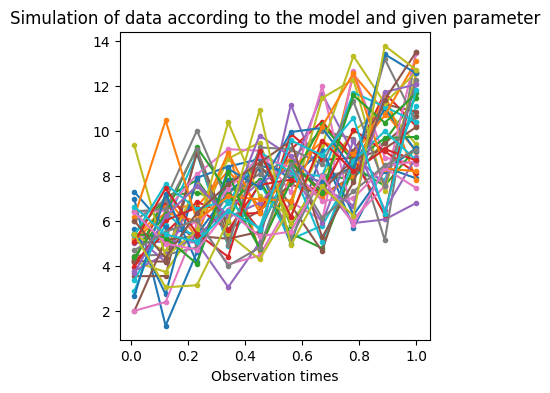

In [4]:
myModel = LinearMixedEffectsModel(N=40, J=10, P=100)

p_star = myModel.new_params(
    mean_latent=jnp.array([5]),
    cov_latent=jnp.diag(jnp.array([0.1])),
    var_residual=1,
    beta=jnp.concatenate(
        [
            jnp.array([5, -15, 20]),
            jnp.zeros(shape=(myModel.P // 2 - 3,)),
            jnp.array([-10, 15, 5]),
            jnp.zeros(shape=(myModel.P // 2 - 3,)),
        ]
    ),
)

myobs, mysim = myModel.sample(p_star, jrd.PRNGKey(0))

ax = sdgplt.ax(4, 4)
_ = ax.plot(myobs["mem_obs_time"].T, myobs["Y"].T, ".-")
ax.set_title("Simulation of data according to the model and given parameter")
ax.set_xlabel("Observation times")

In [5]:
from sdg4varselect.outputs import MultiGDResults
from sdg4varselect.algo import StochasticProximalGradientDescentPrecond as SPGD
import sdg4varselect.algo.preconditioner as preconditioner

FIM = preconditioner.Fisher()
algo = SPGD(FIM, lbd=800, save_all=False)
algo.init_mcmc(myModel, adaptative_sd=False)  # , sd={"b": 5, "phi2": 20})

theta0 = 0.2 * jrd.normal(jrd.PRNGKey(0), shape=(myModel.parametrization.size,))


def one_estim(prngkey, model, data, lbd):
    prngkey_theta, prngkey = jrd.split(prngkey)
    theta0 = 0.2 * jrd.normal(prngkey_theta, shape=(model.parametrization.size,))
    algo.set_seed(prngkey)
    algo.lbd = lbd
    res = algo.fit(model, data, theta0)
    return res


def one_estim_clever(prngkey, model, theta0, data, lbd):
    algo.set_seed(prngkey)
    algo.lbd = lbd
    res = algo.fit(model, data, theta0)
    return res


# res = one_estim_clever(jrd.PRNGKey(0), myModel, theta0, data=myobs, lbd=0.0001)

# multi_estim = MultiGDResults(
#     [one_estim(jrd.PRNGKey(i), myModel, myobs, lbd=0.0001) for i in range(1)]
# )
# multi_estim.last_theta

In [6]:
from sdg4varselect._regularization_function import (
    regularization_path,
    regularization_path_clever,
)

lbd_set = jnp.linspace(10**-1, 10**0, num=10)
multi_estim = regularization_path(
    one_estim,
    jrd.PRNGKey(0),
    lbd_set,
    model=myModel,
    data=myobs,
)

multi_estim_clever = regularization_path_clever(
    one_estim_clever,
    jrd.PRNGKey(0),
    lbd_set,
    theta0=0.2 * jrd.normal(jrd.PRNGKey(0), shape=(myModel.parametrization.size,)),
    model=myModel,
    data=myobs,
)

In [7]:
estim_no_pen = one_estim(jrd.PRNGKey(0), myModel, data=myobs, lbd=None)

In [8]:
from sdg4varselect.algo.sto_prox_grad_descent_precond import proximal_operator
from sdg4varselect.outputs import RegularizationPath, GDResults
from datetime import datetime


def speed_prox(lbd, theta_start):
    start = datetime.now()

    log_likelihood_kwargs = algo.get_log_likelihood_kwargs(myobs)
    theta = theta_start
    p = proximal_operator(
        theta,
        stepsize=1,
        lbd=lbd,
        hd_mask=myModel.hd_mask,
    )

    return algo.results_warper(
        myModel,
        myobs,
        [(theta, theta, None), (p, p, None)],
        chrono=datetime.now() - start,
    )

In [9]:
lbdset = 10 ** jnp.linspace(-1, 2, num=100)
speed_reg = RegularizationPath(
    [speed_prox(lbd, theta_start=estim_no_pen.theta_reals1d[-1]) for lbd in lbdset],
    lbd_set=lbdset,
)
speed_reg.update_bic(myModel)

In [10]:
i = 0

theta_start = multi_estim[i].theta_reals1d[-1]
a, b = jnp.log10(multi_estim.lbd_set[i : (i + 2)])
new_lbd_set = 10 ** jnp.linspace(a, b, num=10)


new_reg = RegularizationPath(
    [res for res in multi_estim[:i]]
    + [speed_prox(lbd, theta_start=theta_start) for lbd in new_lbd_set]+[res for res in multi_estim[(i+1):]],
    lbd_set=jnp.concatenate([lbd_set[:i], new_lbd_set, lbd_set[(i+1):]]),
)
new_reg.update_bic(myModel)

0:01:12.819125
0:01:10.117879
0:00:18.794681


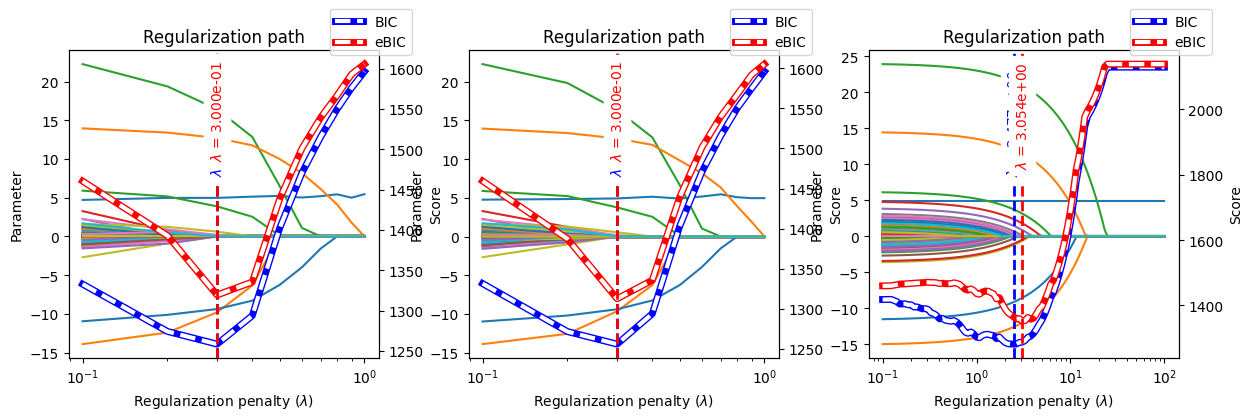

In [11]:
subfigs = sdgplt.figure(4, 4 * 3).subfigures(1, 3)

multi_estim.plot(subfigs[0], P=myModel.P)
print(multi_estim.chrono)

multi_estim_clever.plot(subfigs[1], P=myModel.P)
print(multi_estim_clever.chrono)

speed_reg.plot(subfigs[2], P=myModel.P)
print(speed_reg.chrono)

In [12]:
t = multi_estim_clever[2].theta_reals1d[0,]
print(t[:5])
dt = algo.get_log_likelihood_kwargs(myobs)
print(dt["b"])
jac = myModel.jac_log_likelihood(t, **dt)
print(jac.mean(axis=0)[:5])
algo._preconditioner.get_preconditioned_gradient(jac.mean(axis=0), jac, 1)[1][:5]

[  5.02286755 -10.4825437    0.55163324   4.84841283 -12.56542532]
[5.0205837  4.9953584  4.99540915 5.00374122 4.99517165 5.03176428
 4.99805984 5.00360785 5.01213808 4.995437   4.99638543 5.02326898
 4.99825585 5.00459685 5.00432418 5.01161599 5.01964163 5.00333428
 5.00704224 4.99621954 4.98993271 4.99672984 5.00017344 5.01465036
 5.00257264 4.99767818 4.98543073 5.00470203 5.00002399 5.00462291
 4.98402119 4.99290794 5.00630709 5.00086743 4.99564731 5.00409619
 5.00949473 5.0104365  4.99924659 5.0067594 ]
[-7.07010472e+02  8.17099867e+00  2.14933422e-01  7.88717302e-02
 -2.31084825e-02]


Array([-7.07010478e+02,  8.17099875e+00,  2.14933424e-01,  7.88717309e-02,
       -2.31084827e-02], dtype=float64)

In [13]:
multi_estim_clever[2].grad[:3, :5]

Array([[ 1.25817815e-07,  5.30775122e-10,  2.07934326e-09,
        -2.22936897e-10, -2.26544760e-10],
       [-9.68605983e-06,  3.15024207e-04, -2.56782906e-04,
         7.37114314e-05, -2.39556141e-03]], dtype=float64)

In [14]:
t = multi_estim_clever[1].theta_reals1d[-1]
myModel.parametrization.reals1d_to_params(t)

Parameters(mean_latent=Array([5.02286742], dtype=float64), cov_latent=Array([[2.80209612e-05]], dtype=float64), var_residual=Array(1.00652849, dtype=float64), beta=Array([ 4.84841283e+00, -1.25654253e+01,  1.98388800e+01,  1.24174672e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.44957571e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.27397233e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.89955253e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.84976347e-02,
        0.00000000e+00,  0.00000000e+00, -1.00698193e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.0

In [15]:
jnp.argmin(multi_estim.ebic)

Array(2, dtype=int64)

In [16]:
myModel.hstack_params(p_star)

Array([  5. ,   0.1,   1. ,   5. , -15. ,  20. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. , -10. ,
        15. ,   5. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ], dtype=float64)

In [17]:
multi_estim[jnp.argmin(multi_estim.ebic)].last_theta

Array([ 4.94944346e+00,  4.96516905e-06,  1.16858095e+00,  4.97584047e+00,
       -9.80119213e+00,  1.64276508e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

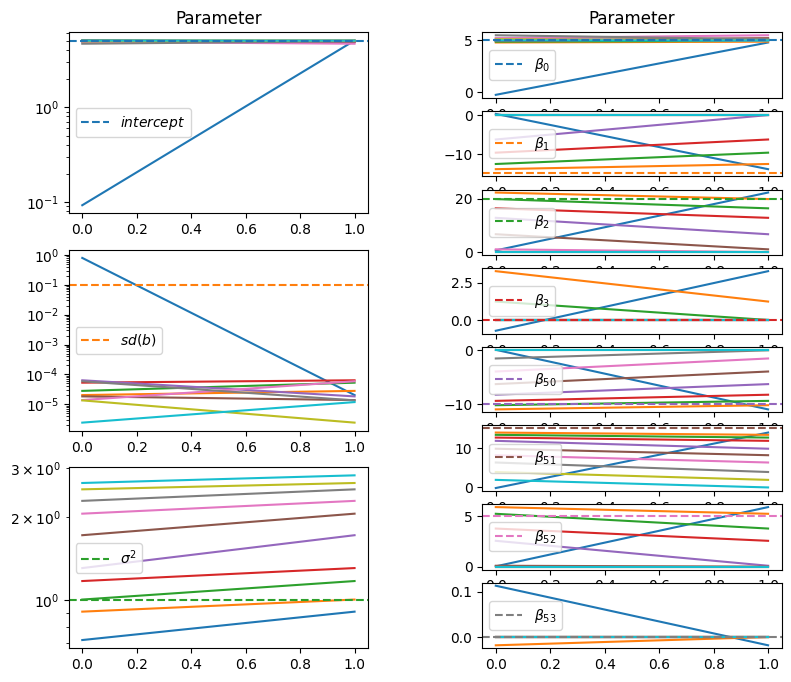

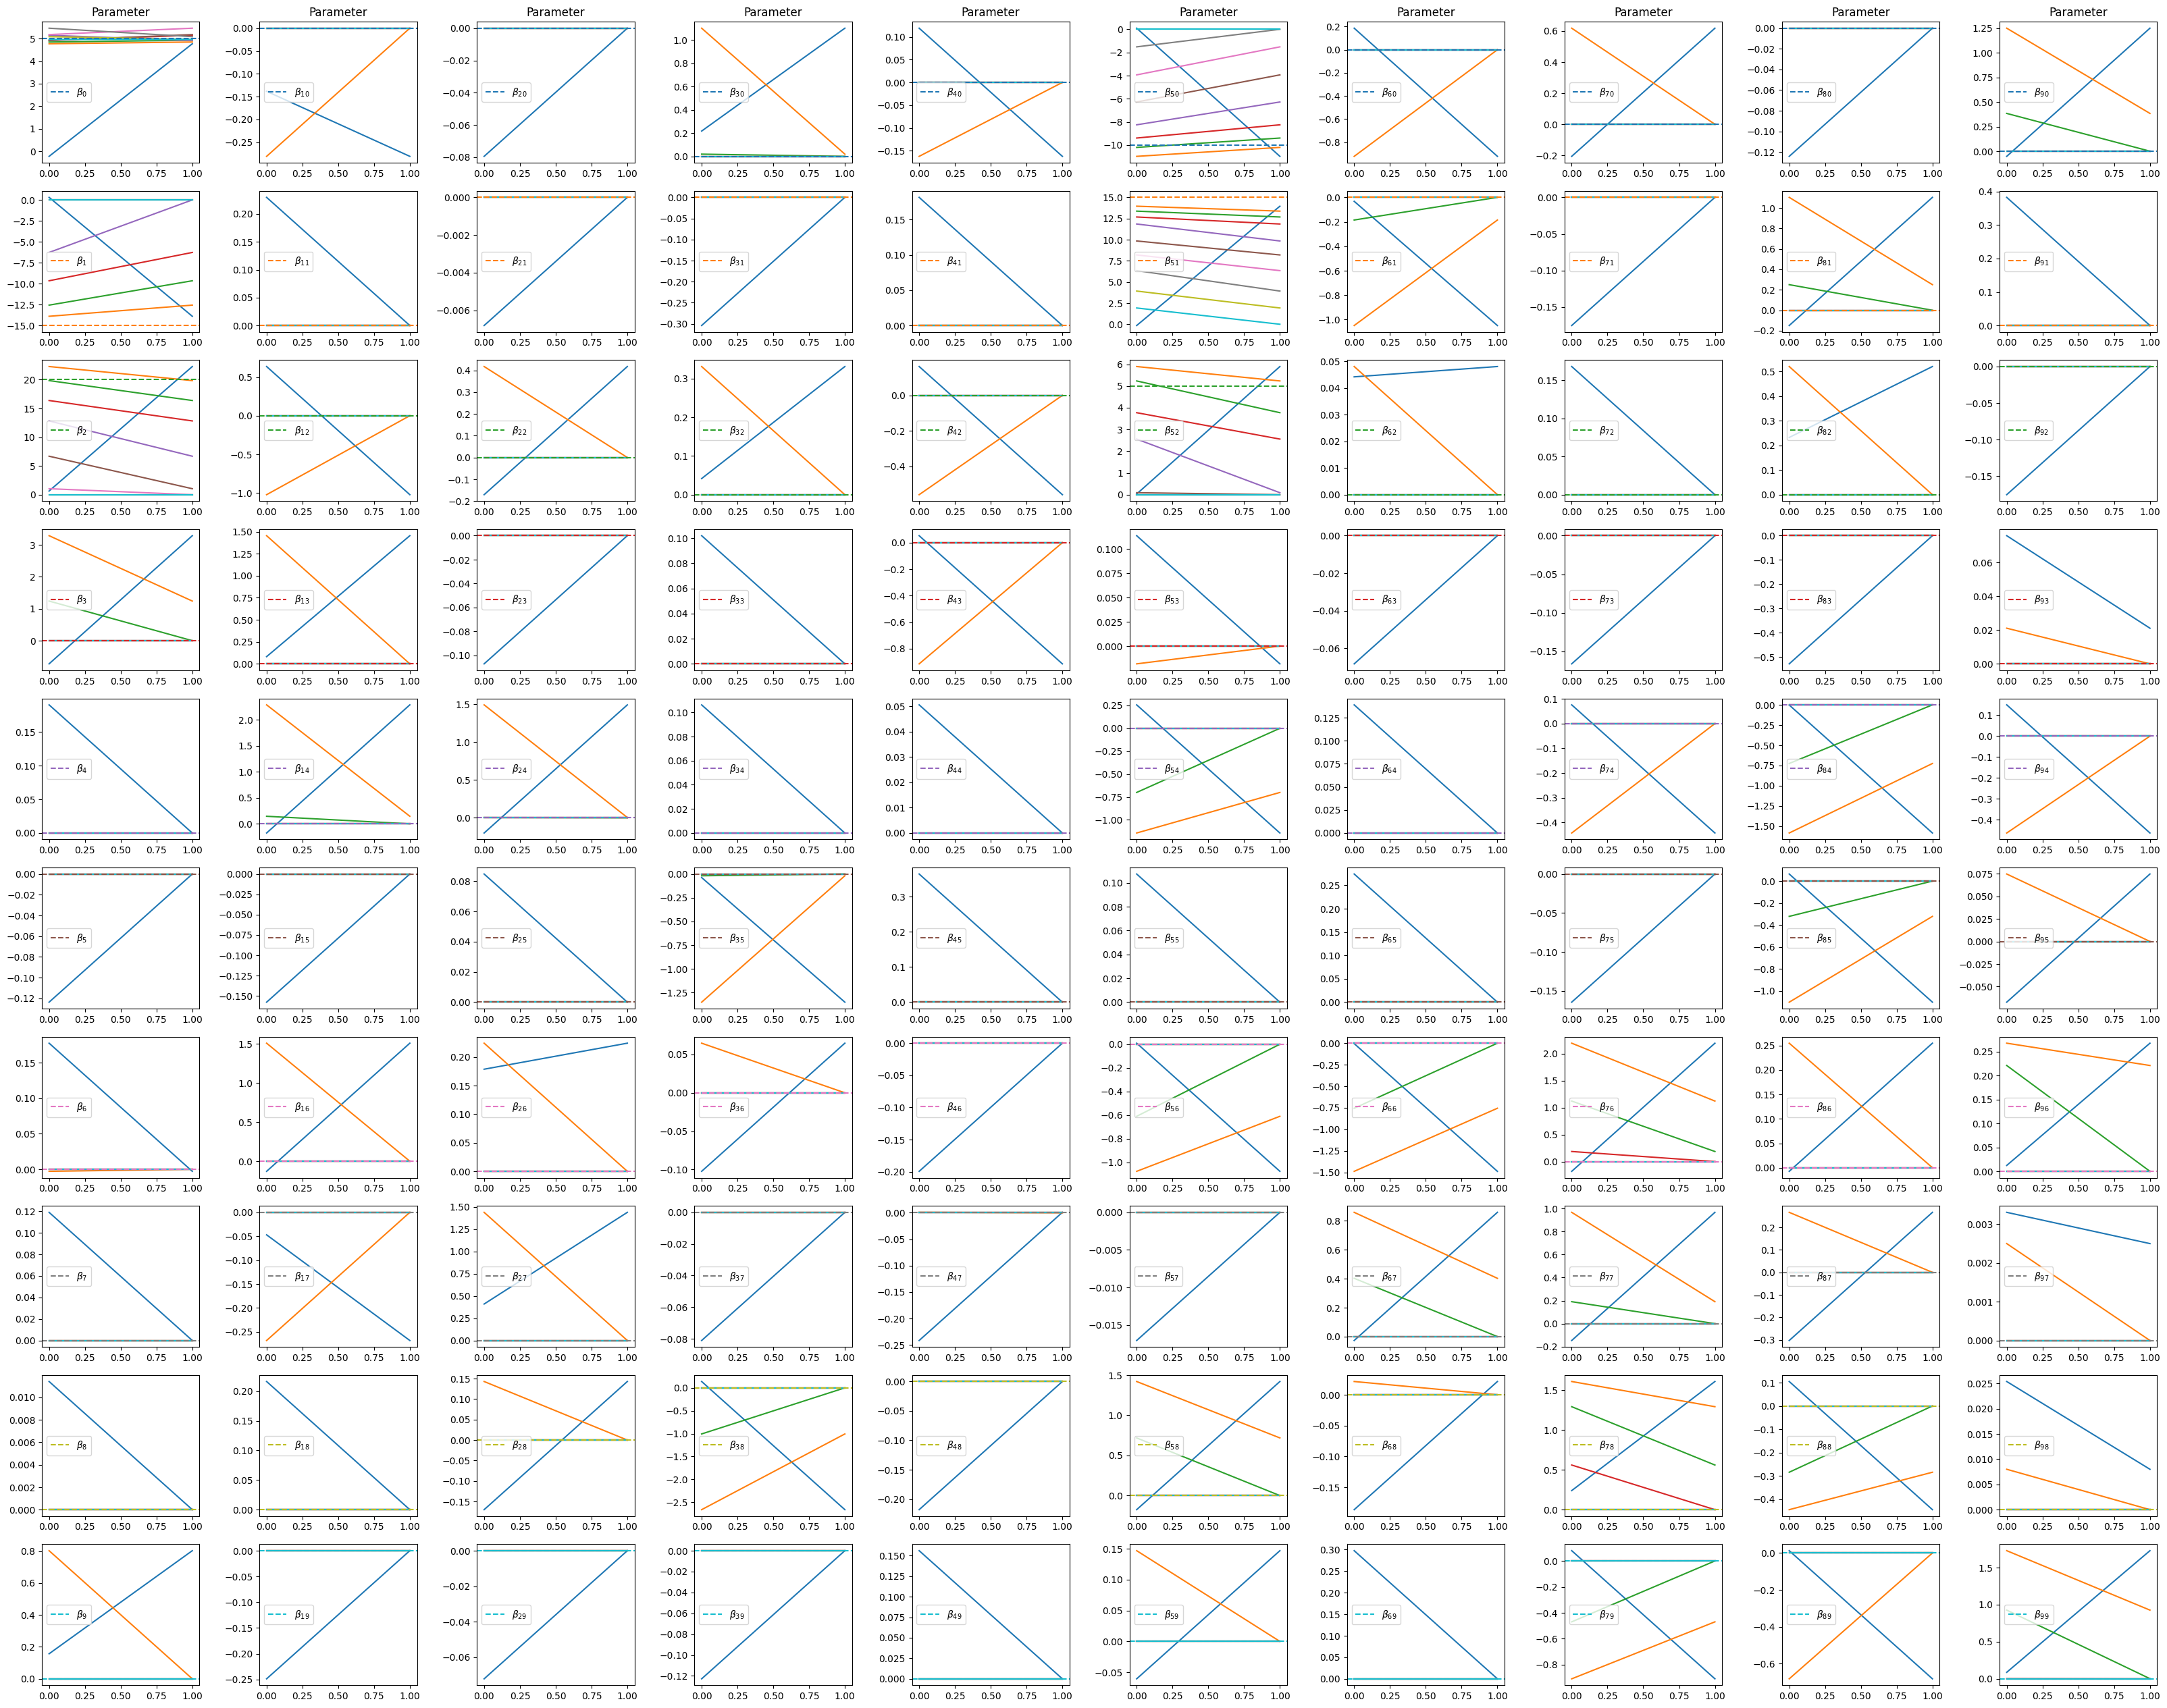

In [18]:
p_names = ["$intercept$", "$sd(b)$", "$\\sigma^2$"] + [
    f"$\\beta_{{{i}}}$" for i in range(myModel.P)
]

r = multi_estim_clever  # [2]

fig = sdgplt.figure(8, 8)
_ = sdgplt.plot_theta(
    r,
    fig=fig.subfigures(1, 2, wspace=0.07),
    params_star=p_star,
    params_names=p_names,
    id_to_plot=[
        [0, 1, 2],
        [
            3,
            4,
            5,
            6,
            myModel.P // 2 + 3,
            myModel.P // 2 + 4,
            myModel.P // 2 + 5,
            myModel.P // 2 + 6,
        ],
    ],
)

fig = sdgplt.figure(8 * 4, 8 * 4)
_ = sdgplt.plot_theta(
    r,
    fig=fig.subfigures(1, 10, wspace=0.07),
    params_star=p_star,
    params_names=p_names,
    id_to_plot=[[i + 10 * j + 3 for i in range(myModel.P // 10)] for j in range(10)],
)

$$\argmin_\lambda ( BIC(\hat\theta_\lambda))$$

$$prox_{\lambda, A} ( \theta_k)$$

$$argmin_\lambda ( BIC(\hat\theta, \lambda))$$

Pour $\theta$ fixé

$$(prox_{\lambda, A}(\theta))_\lambda$$